# Roteiro de trabalho

### Tempos dos vídeos
- (IT) Insulina Tradicional (15:00) $\rightarrow$ 900 segundos
- (GT) Glucagon Tradicional (14:57) $\rightarrow$ 897 segundos
- (IA) Insulina Ativa (19:26) $\rightarrow$ 1166 segundos
- (GA) Glucagon Ativa (20:43) $\rightarrow$ 1243 segundos

### Participante deste roteiro:
- Maria Victoria: GT e IA

In [1]:
import sys
import mne
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
from matplotlib import rcParams

#### Definição do objeto MNE info

In [2]:
n_channels = 8
ch_types = ['eeg'] * n_channels
sfreq = 250
ch_names = ["F3", "Fz", "F4", "C3", "Cz", "C4", "P3", "P4"]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
info.set_montage("standard_1020")

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


#### Carregamento dos dados e transformação para objeto MNE RawArray

**Glucagon Tradicional (GT)**
- Início da aula: 0:05
- Início do mini teste: 14:44
- Fim: 15:58 (corte devido à falha de eletrodos)

**Insulina Ativa (IA)**
- Início da aula: 0:08
- Fim da aula: 20:02
- Início do mini teste: 20:23
- Fim: 23:10

**Teste Final (TF)**
- Início basal: 3:28
- Fim basal / Início do teste: 4:28
- Fim do teste: 12:29

In [3]:
# Aula GT: 1250 até 221000 [879 segundos]
# Mini Teste GT: 221250 até 239500 [73 segundos]
gt = '../dataset-s7/GT/OpenBCI-RAW-2023-09-19_14-58-42_GT.txt'
gt_ob = np.loadtxt(gt, delimiter=',', skiprows=5, usecols=range(1, 9))

# Removendo trechos de pré-início e pós-fim
data_gt = gt_ob[1250:221000, :]
data_gt_test = gt_ob[221250:239500, :]

# Aula IA: 2000 até 300500 [1194 segundos]
# Mini Teste IA: 305750 até 347250 [167 segundos]
ia = '../dataset-s7/IA/OpenBCI-RAW-2023-09-28_16-51-25_IA.txt'
ia_ob = np.loadtxt(ia, delimiter=',', skiprows=5, usecols=range(1, 9))

# Removendo trechos de pré-início e pós-fim
data_ia = ia_ob[2000:300500, :]
data_ia_test = ia_ob[305750:347250, :]


# Teste Final: 67000 até 186250 [477 segundos]
tf = '../dataset-s7/TF/OpenBCI-RAW-2023-11-07_13-17-01_TF.txt'
tf_ob = np.loadtxt(tf, delimiter=',', skiprows=5, usecols=range(1, 9))

# Removendo trechos de pré-início e pós-fim
data_tf = tf_ob[67000:186250, :]

X = {
    'gt': mne.io.RawArray(data_gt.T, info),
    'gt_test': mne.io.RawArray(data_gt_test.T, info),
    'ia': mne.io.RawArray(data_ia.T, info),
    'ia_test': mne.io.RawArray(data_ia_test.T, info),
    'tf': mne.io.RawArray(data_tf.T, info),
}

Creating RawArray with float64 data, n_channels=8, n_times=219750
    Range : 0 ... 219749 =      0.000 ...   878.996 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=18250
    Range : 0 ... 18249 =      0.000 ...    72.996 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=298500
    Range : 0 ... 298499 =      0.000 ...  1193.996 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=41500
    Range : 0 ... 41499 =      0.000 ...   165.996 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=119250
    Range : 0 ... 119249 =      0.000 ...   476.996 secs
Ready.


#### Filtragem dos dados

Primeiramente, atenua-se a frequência de 60Hz evitando a interferência da rede elétrica e, posteriormente, obtem-se a faixa de frequência desejada de 4 a 100Hz.

In [4]:
for key in X:
    X[key].notch_filter(freqs=60)
    X[key].filter(l_freq=4, h_freq=100)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 413 samples (1.652 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband

#### Janela Deslizante

O trecho a seguir determina a porcentagem do tempo em que cada banda de frequência é dominante ao longo de uma janela de tempo específica.

In [5]:
sr = 250            # Taxa de amostragem dos dados do EEG (250Hz)
jump = 5            # Tamanho da janela de análise (5 em 5 segundos)
size = sr * jump    # Número de pontos de dados em cada janela de análise

# Definindo os limites das bandas de frequência (em Hz)
theta_band = (4, 8)       # Theta: 4 - 8 Hz
alpha_band = (8, 13)      # Alpha: 8 - 13 Hz
beta_band = (13, 30)      # Beta: 13 - 30 Hz
gamma_band = (30, 100)    # Gamma: 30 - 100 Hz


total_pc = {}
data_names = ('gt', 'gt_test', 'ia', 'ia_test', 'tf')

# X contém os cinco conjuntos de dados de EEG para análise
for k, data in enumerate(X.values()):
    results = [0, 0, 0, 0] # Contagem de dominância de cada banda

    data.set_eeg_reference(ref_channels='average', projection=False)
    
    # Percorre os dados em incrementos de sr (1 segundo) extraindo janelas de tamanho size (5s)
    for i in range(0, int(data.times[-1] - jump), 1):
        tmin = i
        tmax = i + jump

        cut = data.copy().crop(tmin=tmin, tmax=tmax).get_data()

        # Número de pontos por segmento
        n_per_seg = 128
        # Quantidade de sobreposição entre segmentos
        n_overlap = n_per_seg // 2 # 64
        
        # Calculando a densidade espectral de potência (PSD)
        freqs, psd = welch(cut, fs=sr, nperseg=n_per_seg, noverlap=n_overlap)
        
        # realizando a média dos 8 eletrodos
        X = np.average(psd, axis=0)

        # Encontrar os índices correspondentes às frequências de interesse
        theta_idxs = np.where((freqs >= theta_band[0]) & (freqs <= theta_band[1]))[0]
        alpha_idxs = np.where((freqs >= alpha_band[0]) & (freqs <= alpha_band[1]))[0]
        beta_idxs = np.where((freqs >= beta_band[0]) & (freqs <= beta_band[1]))[0]
        gamma_idxs = np.where((freqs >= gamma_band[0]) & (freqs <= gamma_band[1]))[0]

        # Calculando a potência em cada banda de frequência por meio da integração da PSD
        bands = [np.sum(X[theta_idxs]), np.sum(X[alpha_idxs]), np.sum(X[beta_idxs]), np.sum(X[gamma_idxs])]
        # Calculando a pontuação de cada banda para mostrar a porcentagem futura
        results[np.argmax(bands)] += 1

    total = sum(results)
    percentages = [round((count/total) * 100, 2) for count in results]
    print(data.__str__())
    total_pc[data_names[k]] = percentages

print(total_pc)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawArray | 8 x 219750 (879.0 s), ~13.4 MB, data loaded>
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
<RawArray | 8 x 18250 (73.0 s), ~1.1 MB, data loaded>
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
<RawArray | 8 x 298500 (1194.0 s), ~18.2 MB, data loaded>
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
<RawArray | 8 x 41500 (166.0 s), ~2.6 MB, data loaded>
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
<RawArray | 8 x 119250 (477.0 s), ~7.3 MB, data loaded>
{'gt': [78.35, 0.46, 1.6, 19.59], 'gt_test': [68.66, 0.0, 0.0, 31.34], 'ia': [57.83, 1.01, 0.42, 40.74], 'ia_test': [84.38, 0.0, 0.0, 15.62], 'tf': [23.35, 1.7, 0.42, 74.52]}


**Antes da aplicação do CAR:**

{'gt': [76.22, 0.11, 1.82, 21.84], 'gt_test': [93.15, 0.0, 0.0, 6.85], 'ia': [33.08, 0.0, 1.26, 65.66], 'ia_test': [40.36, 0.0, 0.0, 59.64], 'tf': [9.64, 1.26, 1.05, 88.05]}

**Após a aplicação do CAR:**

{'gt': [80.87, 0.46, 1.03, 17.64], 'gt_test': [68.66, 0.0, 0.0, 31.34], 'ia': [1.35, 0.0, 0.0, 98.65], 'ia_test': [3.12, 0.0, 0.0, 96.88], 'tf': [1.06, 1.27, 0.21, 97.45]}

Mostrando os gráficos de barra dos resultados.

In [6]:
rcParams['figure.figsize'] = [6., 4.]

def plot_bar(x):
    colors = ('orange', 'green', 'blue', 'purple')
    bars = plt.bar(('theta', 'alpha', 'beta', 'gamma'), x, color=colors)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
    plt.title('Porcentagem da potência em cada banda de frequência')
    plt.xlabel('Banda de Frequência')
    plt.ylabel('Porcentagem durante a atividade')
    plt.show()


Aplicando os valores de porcentagens obtidos na função de gráfico

Glucagon Tradicional


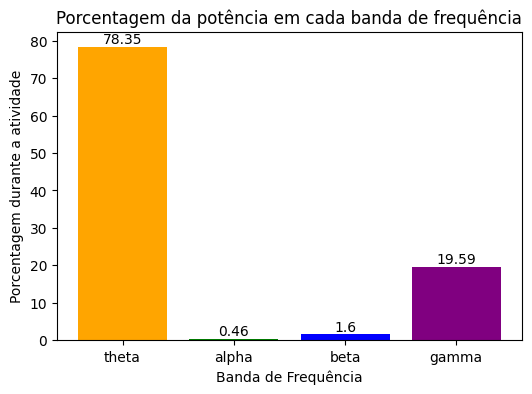

Glucagon Tradicional - Teste


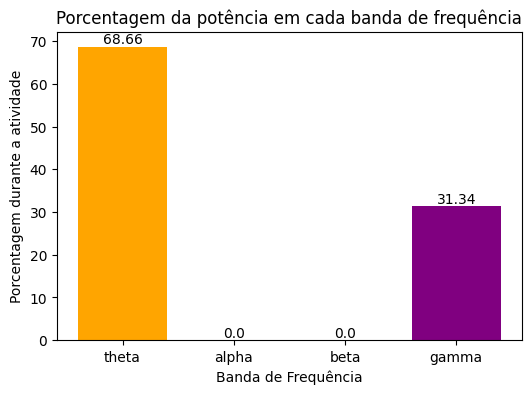

Insulina Ativa


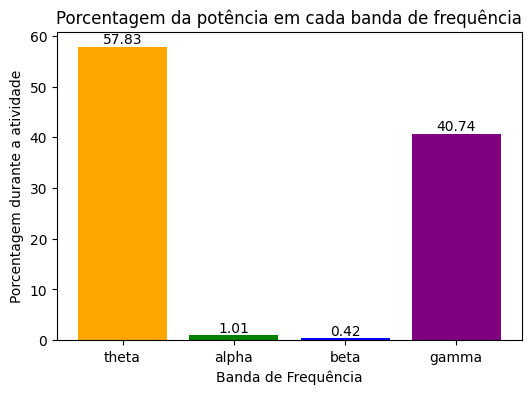

Insulina Ativa - Teste


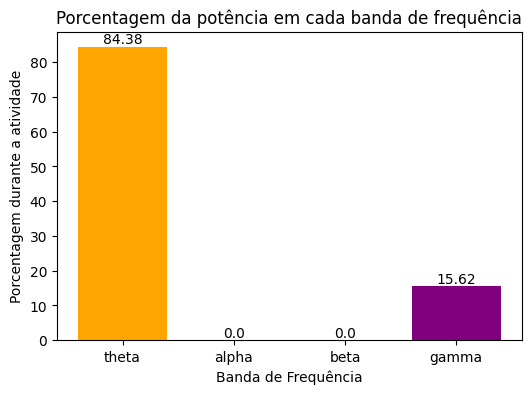

Teste Final


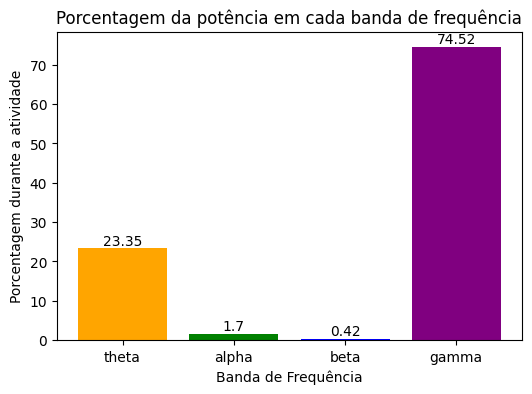

In [7]:
print('Glucagon Tradicional')
plot_bar(total_pc['gt'])
print('Glucagon Tradicional - Teste')
plot_bar(total_pc['gt_test'])

print('Insulina Ativa')
plot_bar(total_pc['ia'])
print('Insulina Ativa - Teste')
plot_bar(total_pc['ia_test'])

print('Teste Final')
plot_bar(total_pc['tf'])

#### Tarefa 1 - Aplicando um Filtro Espacial nos Dados:

Realizando a média dos 8 eletrodos, analizar os canais separadamente. Para isso, vamos aplicar o filtro espacial, no qual podemos utilizar algoritmos específicos para a análise de EEG utilizando o CAR (Common Average Reference). Na biblioteca MNE existe o método `set_eeg_reference`, que pode ser utilizado para aplicar o filtro espacial.

Para aplicar o `set_eeg_reference`, é necessário que os dados estejam no objeto `RawArray`, que é o objeto que contém o método.

O slice deve ser obtido diretamente do objeto MNE, tendo que nesse caso modificar todo o laço de controle.

`cut = data.get_data(start=i, stop=i+size)`

#### Tarefa 2 - Análise de Recorte Específico

Observar por meio dos códigos, os 3 principais rítmos de interesse (Theta, Beta e Gama), com tempos mais específicos do experimento. Ou seja, até o momento, observamos as porcentagens olhando para todo experimento. Então mesmo obtendo um valor de Beta às vezes baixo, em algum momento considerável da aula assistida, ele pode estar alto. Faça uma análise mais detalhada desses momentos.

Para tal, descubra os segmentos de interesse através da analise dos dados diretamente no software OpenBCI GUI. Posteriormente, pegue as mesmas faixas de tempo, e realize os recortes no código em python para constar a prova de conceito.

Mostre também gráficos no domínio da frequência e/ou espectrograma.